## Creating some test data for ICA

[0.69402093 1.00204259 0.5863633 ]
[-0.01302692  0.10424186 -0.05675493 ... -0.16570747 -0.13573704
 -0.12312108]
[-0.01877021  0.15019987 -0.08177697 ... -0.23876436 -0.19558062
 -0.17740254]


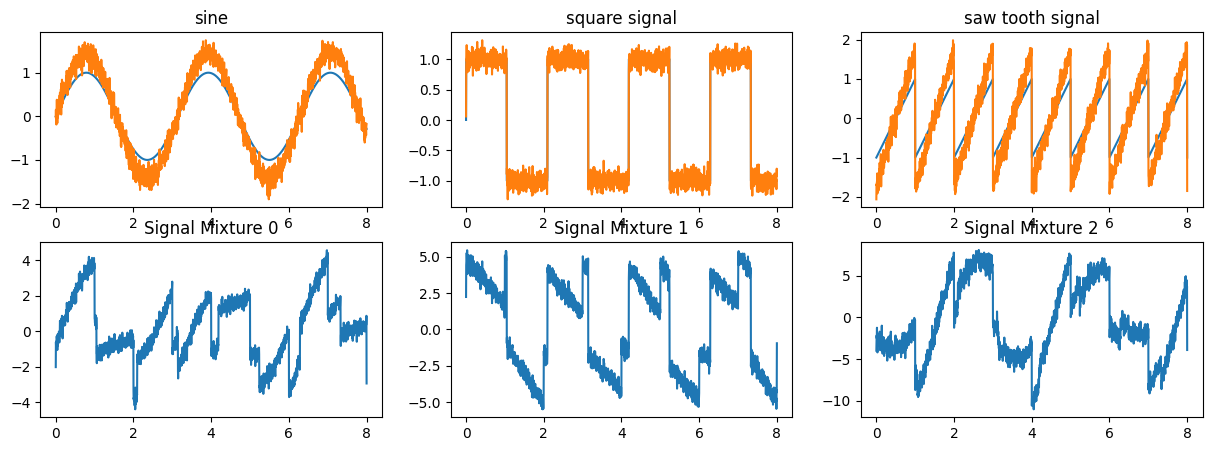

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# 1. Create independent source signals
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.1 * np.random.normal(size=S.shape)  # Add a tiny bit of noise
print(S.std(axis=0))
print(S[:,0])
S /= S.std(axis=0)  # Standardize
print(S[:,0])

# 2. Create a mixing matrix A
A = np.array([[1, 1, 1], [0.25, 3, -1.0], [-4, 1.0, 2.0]])

# 3. Generate the mixed observations
X = np.dot(S, A.T).T

f,ax = plt.subplots(2,3,figsize=(15,5))
ax[0,0].plot(time, s1)
ax[0,0].plot(time, S[:,0])
ax[0,1].plot(time, s2)
ax[0,1].plot(time, S[:,1])
ax[0,2].plot(time, s3)
ax[0,2].plot(time, S[:,2])
ax[0,0].set_title("sine")
ax[0,1].set_title("square signal")
ax[0,2].set_title("saw tooth signal")
for i in range(3):
    ax[1,i].plot(time, X.T[:,i])
    ax[1,i].set_title(f"Signal Mixture {i}")


## define the functions for running ICA

Shape of the data matrix X: (3, 2000)


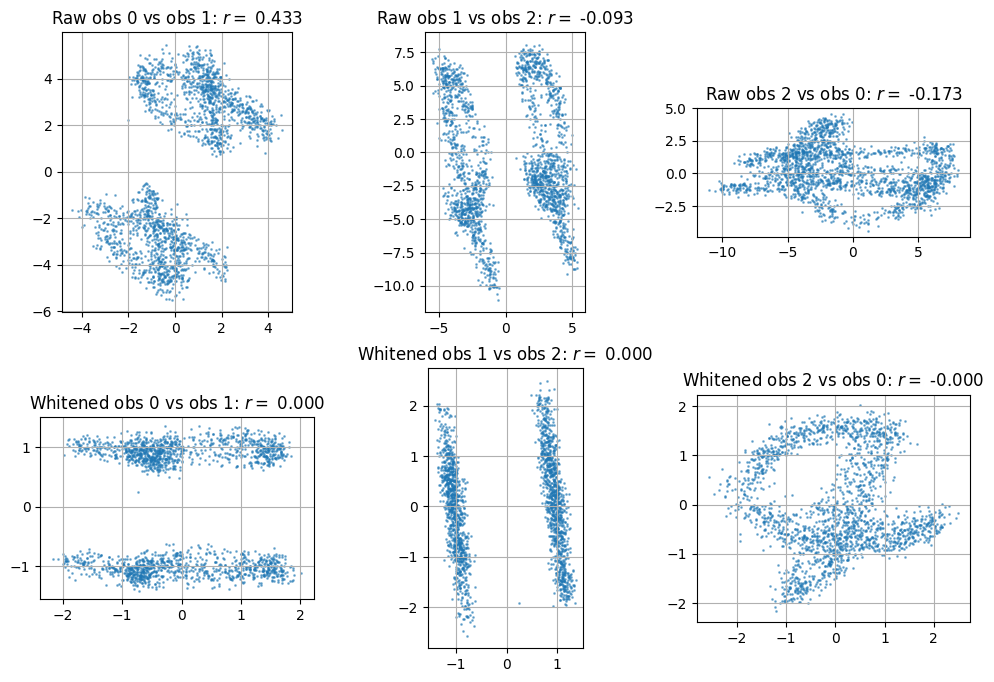

In [152]:
def mean_shift(x):
    """Simple mean shift"""
    return x - np.expand_dims(np.mean(x, axis=1), axis=1)

def whiten(X):
    """
    Given a matrix X, returns the whitened version, where the steps include:

    1.) Mean shifting: to make the later eigen decomposition unbiased from the origin
    2.) Compute covariance of data
    3.) Compute the eigenvectors of the covariance matrix
    4.) Compute the whitening matrix
    5.) Apply the whitening matrix to the data
    """
    #1
    X_mean = np.expand_dims(np.mean(X, axis=1), axis=1)
    X = X - X_mean
    #X = mean_shift(X)
    #2
    cov = X @ X.T / X.shape[1] #calculating covariance over time, so we must divide by number of timepoints
    #3
    D, E = np.linalg.eigh(cov)
    idx = D.argsort()[::-1]
    D, E = D[idx], E[:, idx]
    #4
    D_inv_sqrt = np.diag(1 / np.sqrt(D))
    W = D_inv_sqrt @ E.T #whitening matrix
    #5
    Z = W @ X

    return Z, E, D, X_mean

#make X have the number of observations be along the first dimension
if X.shape[0] == 2000:
    X = X.T

#whiten the data
Z, E, D, X_mean = whiten(X)

f,ax = plt.subplots(2,3,figsize=(12,8))
for j,C in enumerate([X,Z]):
    for i in range(3):
        t1, t2 = C[i,:], C[(i+1)%3,:]
        ax[j,i].scatter(t1, t2, alpha=0.5, s=1)
        ax[j, i].set_aspect('equal')
        ax[j, i].grid(True)
        ax[j, i].set_title(rf"{'Whitened' if j==1 else 'Raw'} obs {i} vs obs {(i+1)%3}: $r=$ {np.corrcoef(t1, t2)[1,0]:.3f}")


Converged after 8 iters


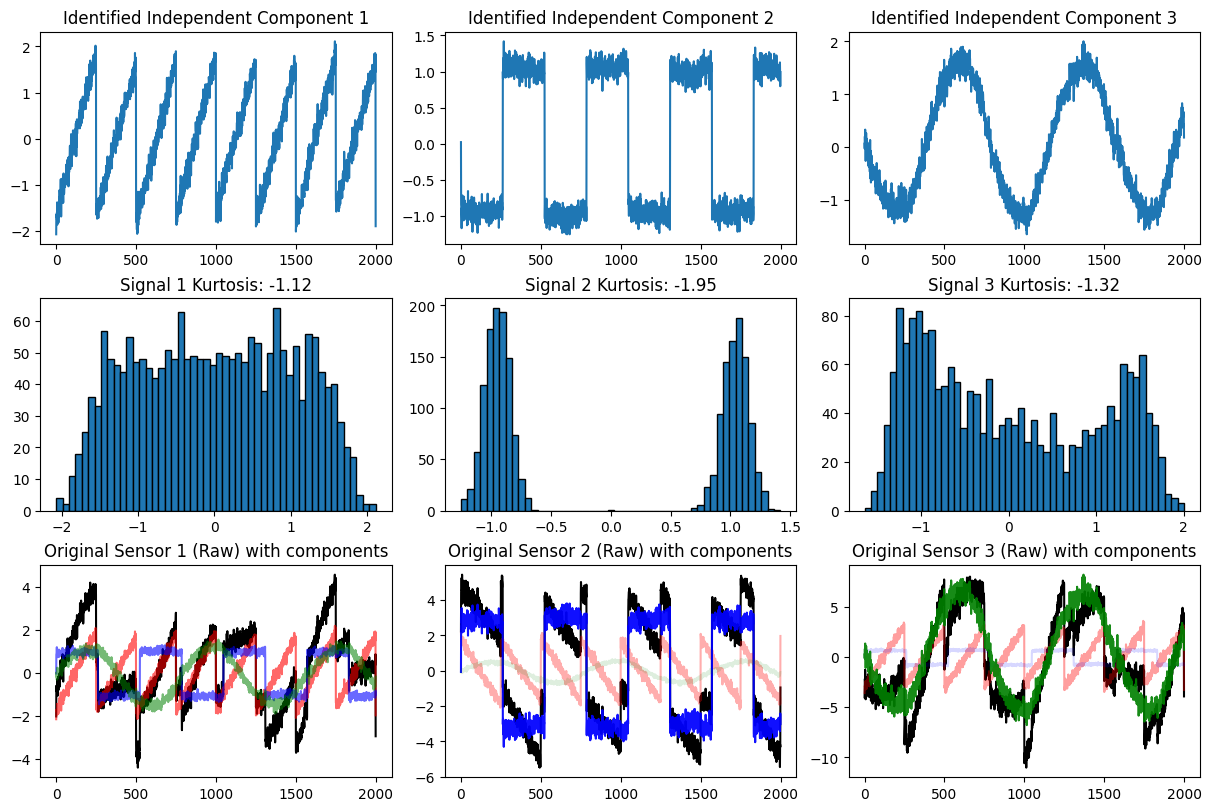

In [281]:
from scipy.stats import kurtosis

## implementation of one kind of ICA
def g(x):
    return np.tanh(x)

def g_prime(x):
    return 1 - g(x) **2

def symmetric_decorrelation(W):
    U,_,Vt = np.linalg.svd(W, full_matrices=False)
    return U @ Vt

def ICA(Z, max_iter=1000, n_components=3, tol=1e-10):
    """
    Z is the whitened data, of shape k x M
    """

    n_features, n_samples = Z.shape

    assert n_components <= n_features

    W = np.random.normal(size=(n_components, n_components))
    W = symmetric_decorrelation(W)
    for i in range(max_iter):
        Wold = W
        Y = W @ Z
        G = g(Y)
        G_prime = g_prime(Y)
        t1 = G @ Z.T / n_samples
        t2 = np.mean(G_prime, axis=1, keepdims=True) * W
        W = t1 - t2
        W = symmetric_decorrelation(W)
        sim = np.abs(np.diag(W @ Wold.T))
        if np.max(np.abs(sim - 1)) < tol:
            print(f"Converged after {i+1} iters")
            break
    return W

def invert_transform(Z, w, D, E, X_mean):
    """
    Z is the whitened data
    w is the vector in question
    D are the eigenvalues from whitening
    E are the eigenvectors
    X_mean is the original data mean
    """
    Q = E @ np.diag(np.sqrt(D)) #inverse whitening
    mixing_vector = Q @ w
    source = w @ Z
    X_single_component = np.outer(mixing_vector, source) + X_mean
    return X_single_component, source

# run ICA
W = ICA(Z)

# get the independent components
S_est = W @ Z

# get the mixing matrix - invert the Whitening and the ICA transform (which is transpose because it is orthogonal)
A_est = E @ np.diag(np.sqrt(D)) @ W.T

f,ax = plt.subplots(3,3,figsize=(12,8), constrained_layout=True)
#plot the orignal with the contributions of each signal
for i in range(3):
    ax[2,i].plot(X[i, :], color='k', alpha=1)
    ax[2,i].set_title(f"Original Sensor {i+1} (Raw) with components")
    for j,color in enumerate(['red', 'blue', 'green']):
        s_data = S_est[j,:]
        ax[2,i].plot(s_data*A_est[i,j], c=color, alpha=np.abs(A_est[i,j]/np.linalg.norm(A_est[i,:])))
#ax[2,0].plot(comp[0, :], color='red', linewidth=2, label='Component 1 Contribution')
#plot the identified sources
for i in range(3):
    s_data = S_est[i,:]
    ax[0,i].plot(s_data)
    ax[0,i].set_title(f"Identified Independent Component {i+1}")
    ax[1,i].hist(s_data, bins=50, edgecolor='black')
    ax[1,i].set_title(f'Signal {i+1} Kurtosis: {kurtosis(s_data):.2f}')


#comp, w_source = invert_transform(Z, w[0,:], D, E, X_mean)

Text(0.5, 0.92, 'Original Data and Micing Matrix Vectors')

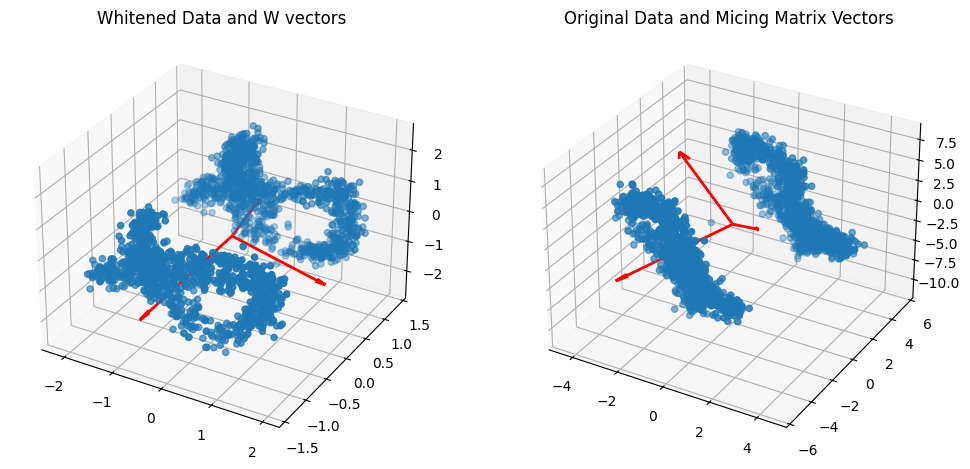

In [289]:
#plot the final W vectors
f = plt.figure(figsize=(12,6))
ax = f.add_subplot(1,2,1, projection='3d')
scatter = ax.scatter(Z[0,:], Z[1,:], Z[2,:])

for i in range(3):
    wp = W[i,:]
    v1,v2,v3 = wp*2
    ax.quiver(0, 0, 0, v1, v2, v3, arrow_length_ratio=0.1, color='red', linewidth=2)

ax2 = f.add_subplot(1,2,2, projection='3d')
scatter = ax2.scatter(X[0,:], X[1,:], X[2,:])
for i in range(3):
    wp = A_est[:,i]
    v1,v2,v3 = wp*2
    ax2.quiver(0, 0, 0, v1, v2, v3, arrow_length_ratio=0.1, color='red', linewidth=2)

ax.set_title(f"Whitened Data and W vectors")
ax2.set_title(f"Original Data and Mixing Matrix Vectors")

## Demonstration of Mean Shift Importance

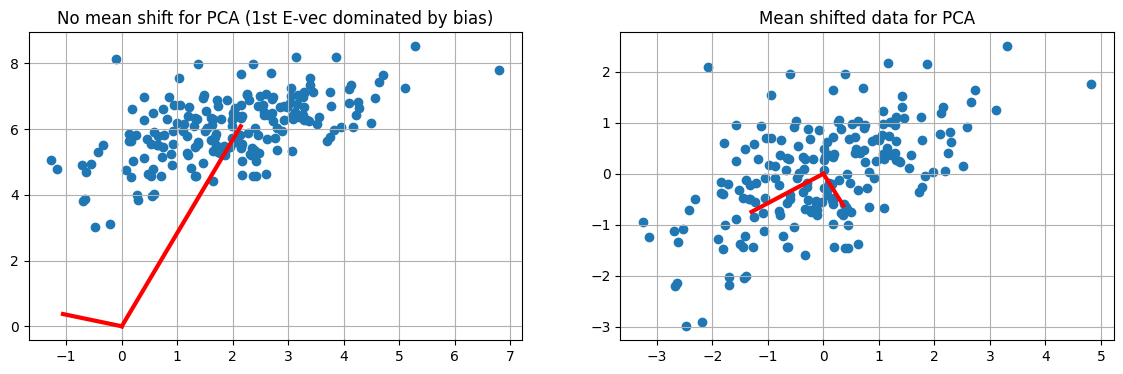

In [295]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate sample data
np.random.seed(42)
n_samples = 200

# Create data centered at (5, 3) with covariance structure
mean = np.array([2, 6])
cov = np.array([[2, 0.8], [0.8, 1]])
data = np.random.multivariate_normal(mean, cov, n_samples)

f,ax = plt.subplots(1,2, figsize=(14,4))

#without centering
cov = data.T@data / data.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.sqrt(evals)
ax[0].scatter(data[:,0], data[:,1])
ax[0].plot([0,evecs[0][0]*evals[0]], [0,evecs[0][1]*evals[0]], color='red', linewidth=3)
ax[0].plot([0,evecs[1][0]*evals[1]], [0,evecs[1][1]*evals[1]], color='red', linewidth=3)

#with centering
data = data-np.mean(data, axis=0)
cov = data.T@data / data.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.sqrt(evals)
ax[1].scatter(data[:,0], data[:,1])
ax[1].plot([0,evecs[0][0]*evals[0]], [0,evecs[0][1]*evals[0]], color='red', linewidth=3)
ax[1].plot([0,evecs[1][0]*evals[1]], [0,evecs[1][1]*evals[1]], color='red', linewidth=3)

ax[0].set_title("No mean shift for PCA (1st E-vec dominated by bias)")
ax[1].set_title("Mean shifted data for PCA")

# ax[0].set_aspect('equal')
# ax[1].set_aspect('equal')
ax[0].grid('on')
ax[1].grid('on')

## Kurtosis of a Signal (non-noise/non-gaussian signal)

Text(0.5, 1.0, 'Histogram of signal')

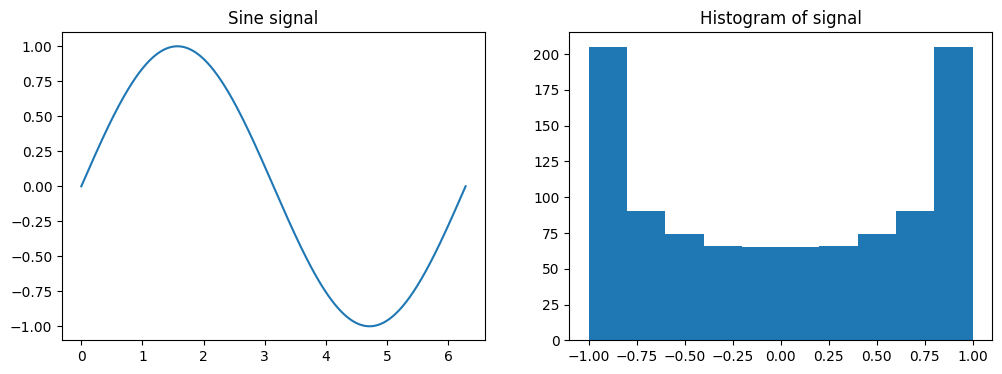

In [296]:
t1 = np.linspace(0, 4*np.pi/2, 1000)
t = np.sin(t1)

f,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(t1, t)
ax[0].set_title("Sine signal")
ax[1].hist(t)
ax[1].set_title("Histogram of signal")

# Scrap code

[-0.01334577  0.99295661  0.11772449]
(3, 2000)


Text(0.5, 1.0, 'Gaussian (kurtosis: -0.09)')

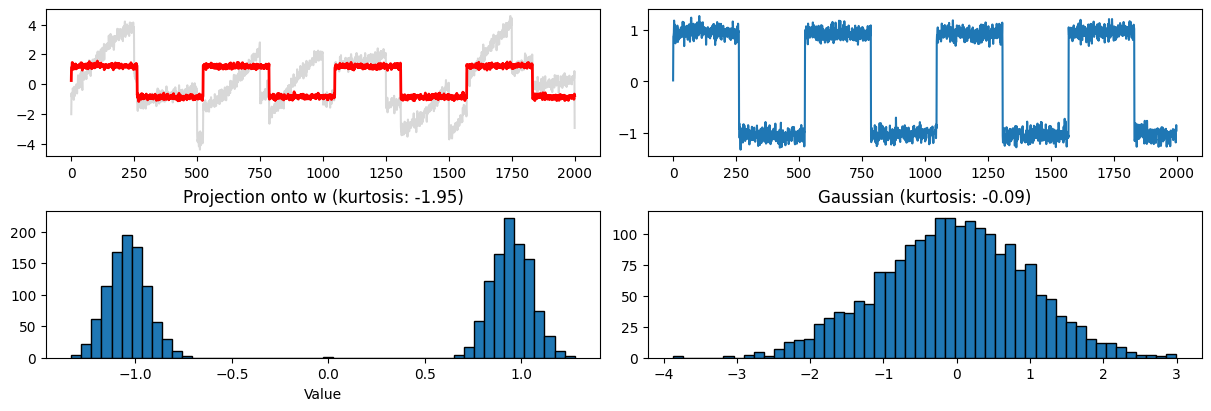

In [216]:

from scipy.stats import kurtosis

def invert_transform(Z, w, D, E, X_mean):
    """
    Z is the whitened data
    w is the vector in question
    D are the eigenvalues from whitening
    E are the eigenvectors
    X_mean is the original data mean
    """
    Q = E @ np.diag(np.sqrt(D)) #inverse whitening
    mixing_vector = Q @ w
    source = w @ Z
    X_single_component = np.outer(mixing_vector, source) + X_mean
    return X_single_component, source

n_features, n_samples = Z.shape

# Create a candidate vector (example: random direction)
w = np.random.randn(n_features)
w = w / np.linalg.norm(w)  # normalize to unit vector
while np.abs(kurtosis(w@Z)) < 1.95:
    w = np.random.randn(n_features)
    w = w / np.linalg.norm(w)  # normalize to unit vector
print(w)
#w = w_vectors[1]

comp, w_source = invert_transform(Z, w, D, E, X_mean)
print(comp.shape)

fig, axes = plt.subplots(2, 2, figsize=(12, 4), constrained_layout=True)
axes[0,0].plot(X[0, :], color='gray', alpha=0.3, label='Original Sensor 1 (Raw)')
axes[0,0].plot(comp[0, :], color='red', linewidth=2, label='Component 1 Contribution')
axes[0,1].plot(w_source)

# # Histogram of the projection
axes[1,0].hist(w_source, bins=50, edgecolor='black')
axes[1,0].set_title(f'Projection onto w (kurtosis: {kurtosis(w_source):.2f})')
axes[1,0].set_xlabel('Value')

# Compare to Gaussian
gaussian_sample = np.random.randn(n_samples)
axes[1,1].hist(gaussian_sample, bins=50, edgecolor='black')
axes[1,1].set_title(f'Gaussian (kurtosis: {kurtosis(gaussian_sample):.2f})')

[ 1.54017854  0.78558787  0.85224926 ... -1.12118839 -1.30660328
  3.00829326]


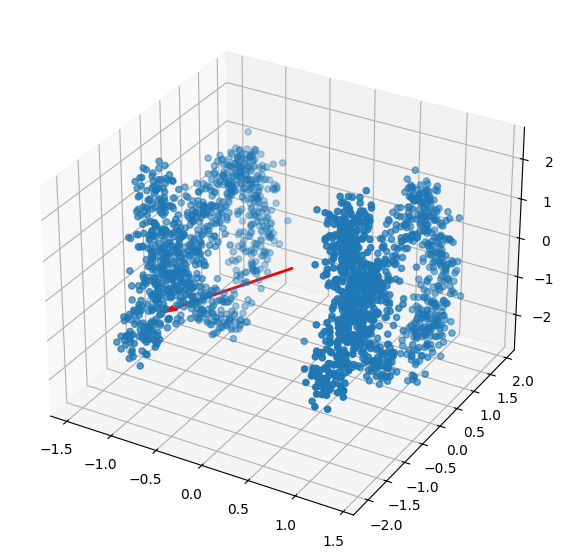

In [134]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
scatter = ax.scatter(Z[1,:], Z[0,:], Z[2,:])

#plot a mixing matrix vector
v1,v2,v3 = mixing_matrix[0,:]
ax.quiver(0, 0, 0, v1, v2, v3, arrow_length_ratio=0.1, color='red', linewidth=2)



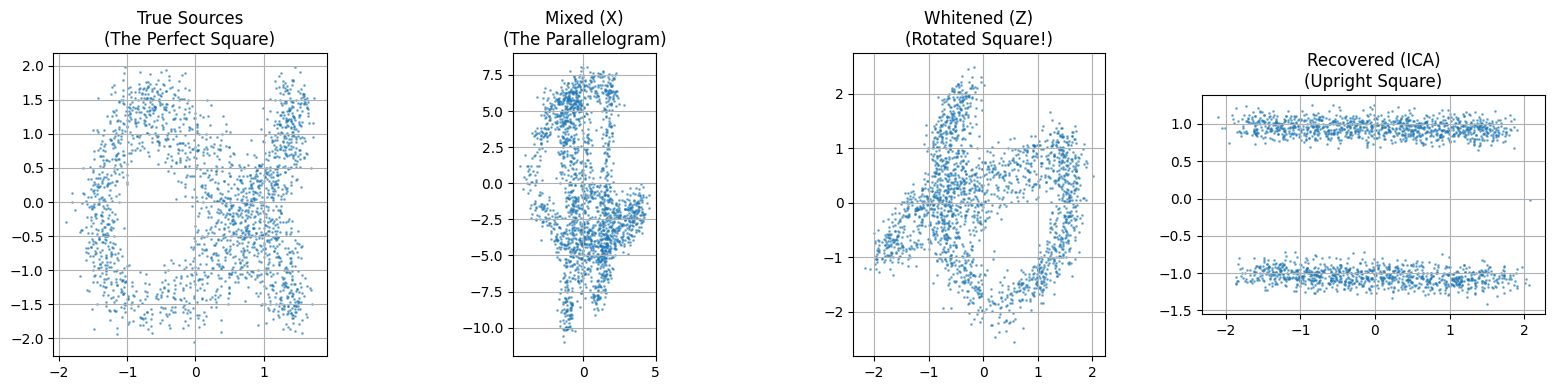

In [157]:
from sklearn.decomposition import FastICA

# 2. Run ICA (Using sklearn for quick visualization)
ica = FastICA(n_components=3, whiten='unit-variance')
S_est = ica.fit_transform(X.T) # Sklearn expects (samples, features)

# --- VISUALIZATION 1: THE GEOMETRY (The "Square") ---
# We plot Signal 0 (Sine) vs Signal 2 (Sawtooth) to see the box
f, ax = plt.subplots(1, 4, figsize=(16, 4))

# 1. True Sources
ax[0].scatter(S[:, 0], S[:, 2], s=1, alpha=0.5)
ax[0].set_title("True Sources\n(The Perfect Square)")

# 2. Mixed Observations
ax[1].scatter(X[0, :], X[2, :], s=1, alpha=0.5)
ax[1].set_title("Mixed (X)\n(The Parallelogram)")

# 3. Whitened
ax[2].scatter(Z[0, :], Z[2, :], s=1, alpha=0.5)
ax[2].set_title("Whitened (Z)\n(Rotated Square!)")

# 4. Recovered
ax[3].scatter(S_est[:, 0], S_est[:, 2], s=1, alpha=0.5)
ax[3].set_title("Recovered (ICA)\n(Upright Square)")

for a in ax:
    a.set_aspect('equal')
    a.grid(True)

plt.tight_layout()
plt.show()

[[-1.03853007 -0.95796925 -1.02851362]
 [ 1.02225561 -0.38618951 -3.04525471]
 [-1.76722446  4.08903232 -0.69597379]]
[[ 1.    1.    1.  ]
 [ 0.25  3.   -1.  ]
 [-4.    1.    2.  ]]


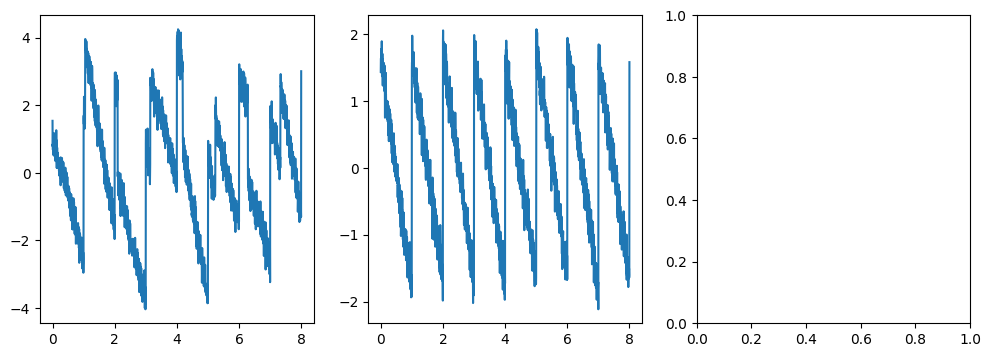

In [141]:
f,ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(time, mixing_matrix[0,:].T@Z)
# ax[1].plot(time, S_est[:, 0])
# ax[1].plot(time, S_est[:, 1])
# ax[2].plot(time, S_est[:, 2])

mixing_matrix = ica.mixing_
print(mixing_matrix)

print(A)

## Demonstration of mean shift importance

Text(0.5, 1.0, 'Mean shifted data for PCA')

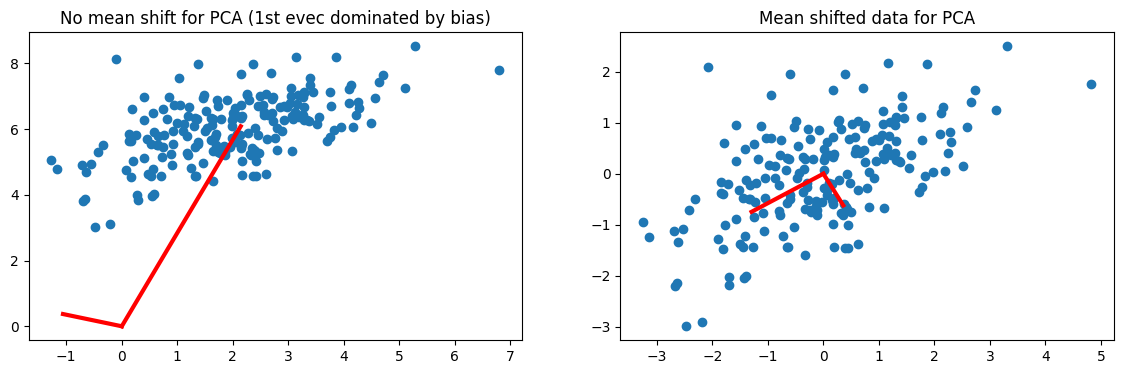

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate sample data
np.random.seed(42)
n_samples = 200

# Create data centered at (5, 3) with covariance structure
mean = np.array([2, 6])
cov = np.array([[2, 0.8], [0.8, 1]])
data = np.random.multivariate_normal(mean, cov, n_samples)

f,ax = plt.subplots(1,2, figsize=(14,4))

#without centering
cov = data.T@data / data.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.sqrt(evals)
ax[0].scatter(data[:,0], data[:,1])
ax[0].plot([0,evecs[0][0]*evals[0]], [0,evecs[0][1]*evals[0]], color='red', linewidth=3)
ax[0].plot([0,evecs[1][0]*evals[1]], [0,evecs[1][1]*evals[1]], color='red', linewidth=3)

#with centering
data = data-np.mean(data, axis=0)
cov = data.T@data / data.shape[0]
evals, evecs = np.linalg.eigh(cov)
evals = np.sqrt(evals)
ax[1].scatter(data[:,0], data[:,1])
ax[1].plot([0,evecs[0][0]*evals[0]], [0,evecs[0][1]*evals[0]], color='red', linewidth=3)
ax[1].plot([0,evecs[1][0]*evals[1]], [0,evecs[1][1]*evals[1]], color='red', linewidth=3)

ax[0].set_title("No mean shift for PCA (1st evec dominated by bias)")
ax[1].set_title("Mean shifted data for PCA")

In [87]:
a = np.array([1,2,3])
a = a/np.linalg.norm(a, axis=0)
b = np.array([4,4,3])
b = b/np.linalg.norm(b)

print(a)
print(b)
print(np.sum(a*a))

[0.26726124 0.53452248 0.80178373]
[0.62469505 0.62469505 0.46852129]
1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate Correlated Data (The "Angled Cigar")
np.random.seed(0)
n_samples = 2000
# Create two gaussian signals
z = np.random.randn(2, n_samples)
# Mix them with a matrix that creates correlation (stretch and rotate)
mixing_matrix = np.array([[3, 1], [1, 0.5]]) 
X = np.dot(mixing_matrix, z)

# Center the data (Mean Shift)
X = X - X.mean(axis=1, keepdims=True)

# 2. Calculate Covariance and Eigendecomposition (PCA steps)
cov = np.cov(X)
D, V = np.linalg.eigh(cov) # D = eigenvalues, V = eigenvectors

# 3. Whiten the Data
# Step A: Rotate (Project onto eigenvectors - this is PCA)
X_pca = np.dot(V.T, X)

# Step B: Scale (Divide by sqrt of eigenvalues - this is Whitening)
# We add a tiny epsilon to avoid division by zero if needed, though unlikely here
scale_matrix = np.diag(1.0 / np.sqrt(D + 1e-10))
X_white = np.dot(scale_matrix, X_pca)

# --- PLOTTING ---
plt.figure(figsize=(12, 5))

# Plot 1: Raw Data (Correlated)
plt.subplot(1, 2, 1)
plt.scatter(X[0], X[1], alpha=0.2, s=5)
plt.title("1. Raw Mean-Shifted Data\n(Correlated 'Cigar')")
plt.axis('equal')
plt.grid(True)

# Plot 2: Whitened Data
plt.subplot(1, 2, 2)
plt.scatter(X_white[0], X_white[1], alpha=0.2, s=5, color='orange')
plt.title("2. Whitened Data\n(Uncorrelated 'Sphere')")
plt.axis('equal')
plt.grid(True)

plt.show()

Text(0.5, 1.0, 'Histogram of signal')

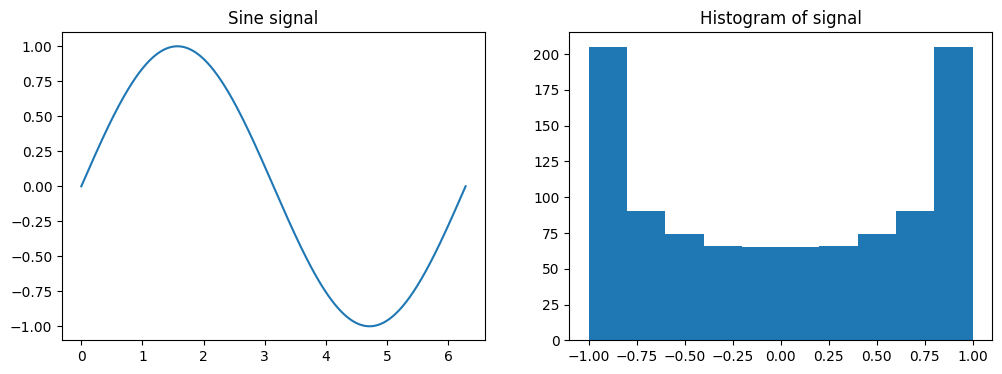

In [218]:
t1 = np.linspace(0, 4*np.pi/2, 1000)
t = np.sin(t1)

f,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(t1, t)
ax[0].set_title("Sine signal")
ax[1].hist(t)
ax[1].set_title("Histogram of signal")

In [220]:
np.linalg.svd(np.array([[2,3], [1, 2], [-10, 11]]))

SVDResult(U=array([[ 0.06400395, -0.8566008 ,  0.5119947 ],
       [ 0.05731586, -0.50904444, -0.85882982],
       [ 0.99630236,  0.08431391,  0.01651596]]), S=array([14.91728803,  4.05888134]), Vh=array([[-0.65546095,  0.75522906],
       [-0.75522906, -0.65546095]]))